In [3]:
import numpy as np 
import pandas as pd
import csv
from sklearn.cluster import DBSCAN 
from sklearn.datasets import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
df=pd.read_csv(r"weather-stations20140101-20141231.csv")
df.head()

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DISCOVERY ISLAND,48.425,-123.226,BC,NaN,NaN,NaN,12.5,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1012475
4,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573


In [5]:
#remove rows that don't have any value in the Tm field
df = df[pd.notnull(df["Tm"])]
df = df.reset_index(drop=True)
df.head(5)

,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,...,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,...,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,...,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,...,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055
3,DUNCAN KELVIN CREEK,48.735,-123.728,BC,7.7,2.0,3.4,14.5,2.0,-1.0,...,2.0,NaN,NaN,11.0,NaN,NaN,NaN,267.7,0.0,1012573
4,ESQUIMALT HARBOUR,48.432,-123.439,BC,8.8,0.0,NaN,13.1,0.0,1.9,...,8.0,NaN,NaN,12.0,NaN,NaN,NaN,258.6,0.0,1012710


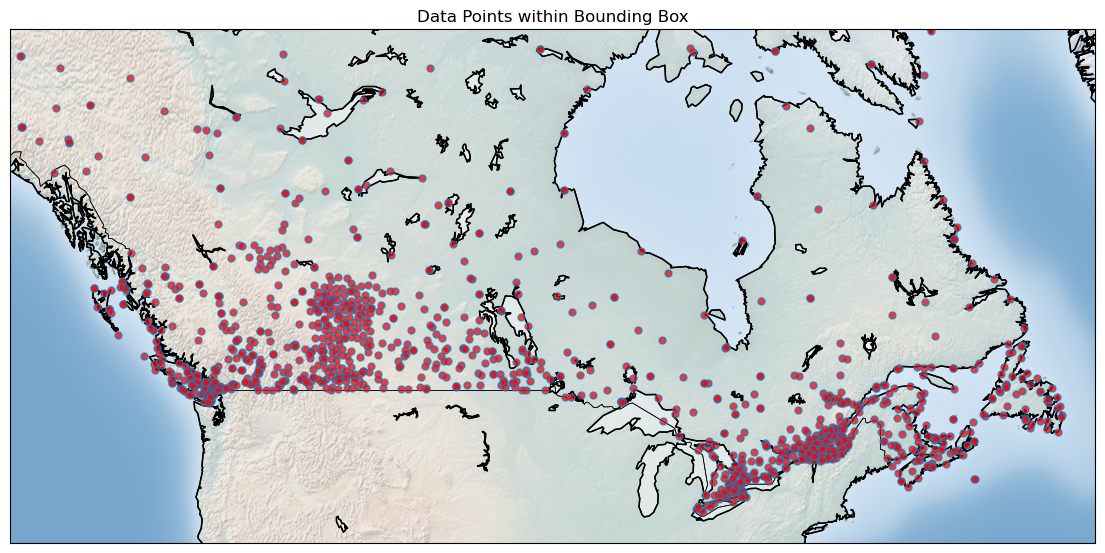

In [13]:
#Visualization of stations on map using basemap package
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np

# Set figure size
rcParams['figure.figsize'] = (14,10)

llon=-140
ulon=-50
llat=40
ulat=65


# Filter data (keeping this step)
df = df[(df['Long'] > llon) & (df['Long'] < ulon) & (df['Lat'] > llat) &(df['Lat'] < ulat)]

# 1. Initialize Map
my_map = Basemap(projection='merc',
             resolution = 'l', area_thresh = 1000.0,
             llcrnrlon=llon, llcrnrlat=llat,
             urcrnrlon=ulon, urcrnrlat=ulat)

# 2. Draw Map Elements
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# 3. Transform Coordinates
# The previous code already calculated xs and ys
xs, ys = my_map(np.asarray(df.Long), np.asarray(df.Lat))
df['xm']= xs.tolist()
df['ym'] =ys.tolist()

# 4. Vectorized Visualization (The Fix!)
# Pass ALL x-coordinates (xs) and ALL y-coordinates (ys) to the plot function at once.
my_map.plot(xs, ys, 
            markerfacecolor=([1,0,0]), 
            marker='o', 
            markersize=5, 
            linestyle='', # Crucial: set linestyle to '' to prevent drawing lines between points
            alpha=0.75) 

plt.title('Data Points within Bounding Box')
plt.show()

In [14]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = df[['xm','ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
df[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

,Stn_Name,Tx,Tm,Clus_Db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


In [15]:
set(labels)

{-1, 0, 1, 2, 3, 4}

Cluster 0, Avg Temp: 6.221192052980132
Cluster 1, Avg Temp: 6.790000000000001
Cluster 2, Avg Temp: -0.49411764705882344
Cluster 3, Avg Temp: -13.87720930232558
Cluster 4, Avg Temp: -4.186274509803922
Cluster 5, Avg Temp: -16.301503759398496
Cluster 6, Avg Temp: -13.599999999999998
Cluster 7, Avg Temp: -9.753333333333334
Cluster 8, Avg Temp: -4.258333333333334


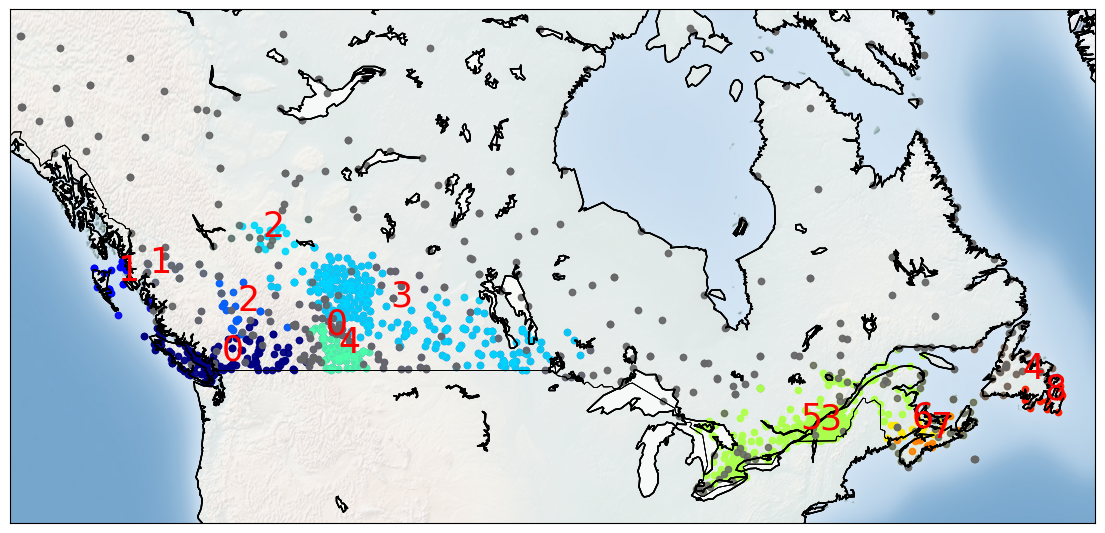

In [20]:
#Visualization of clusters based on location
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[int(clust_number)])
    clust_set = df[df.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))


plt.show()

In [19]:
#Clustering of stations based on their location, mean, max, and min Temperature
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = df[['xm','ym','Tx','Tm','Tn']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
df[["Stn_Name","Tx","Tm","Clus_Db"]].head(5)

,Stn_Name,Tx,Tm,Clus_Db
0,CHEMAINUS,13.5,8.2,0
1,COWICHAN LAKE FORESTRY,15.0,7.0,0
2,LAKE COWICHAN,16.0,6.8,0
3,DUNCAN KELVIN CREEK,14.5,7.7,0
4,ESQUIMALT HARBOUR,13.1,8.8,0


Cluster 0, Avg Temp: 6.221192052980132
Cluster 1, Avg Temp: 6.790000000000001
Cluster 2, Avg Temp: -0.49411764705882344
Cluster 3, Avg Temp: -13.87720930232558
Cluster 4, Avg Temp: -4.186274509803922
Cluster 5, Avg Temp: -16.301503759398496
Cluster 6, Avg Temp: -13.599999999999998
Cluster 7, Avg Temp: -9.753333333333334
Cluster 8, Avg Temp: -4.258333333333334


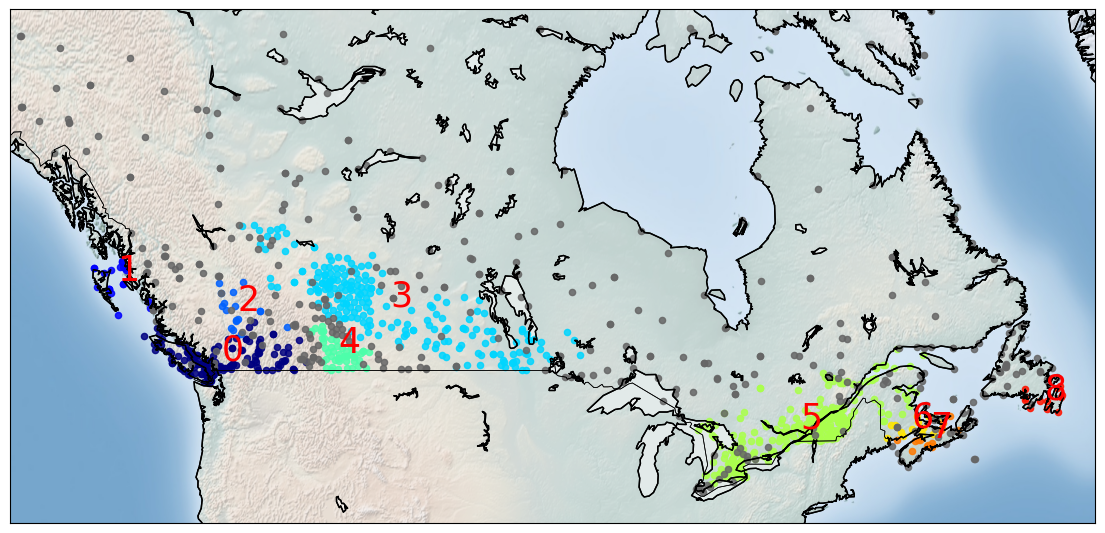

In [22]:
#Visualization of clusters based on location and Temperture
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[int(clust_number)])
    clust_set = df[df.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        print ("Cluster "+str(clust_number)+', Avg Temp: '+ str(np.mean(clust_set.Tm)))

plt.show()